In [13]:
#wandb integration
import wandb

In [14]:


import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
#import tensorflow_probability as tfp

## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components. 

### Q-Network:
The neural network used as a function approximator is defined below

In [15]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 64 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()

QNetwork2: Feel free to experiment more
'''

import torch
import torch.nn as nn  
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
#BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
#BATCH_SIZE = 64         #''' minibatch size '''
#GAMMA = 0.99            #''' discount factor '''
#LR = 5e-4               #''' learning rate '''
#UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer:

This is a 'deque' that helps us store experiences. Recall why we use such a technique.

In [16]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Truncation:
We add a line (optionally) in the code to truncate the gradient in hopes that it would help with the stability of the learning process.

## Agent Code:


In [17]:
from scipy.special import softmax
import random

class Agent():

    def __init__(self, state_size, action_size, seed,\
                 method='softmax',temp=0.9,buffer_size = int(1e5),\
                batch_size = 64 ,gamma = 0.99,lr = 5e-4,update_every = 20,\
                 fc1_units=128, fc2_units=64,momentum_decay =0.9,\
                optimizer='adam'):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.method=method
        self.temp=temp
        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed,fc1_units,fc2_units).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed,fc1_units,fc2_units).to(device)
        self.optimizer =None
        if(optimizer=='adam'):
            self.optimizer=optim.Adam(self.qnetwork_local.parameters(), lr=lr)
        if(optimizer=='nadam'):
            self.optimizer=optim.NAdam(self.qnetwork_local.parameters(), lr=lr,momentum_decay=momentum_decay)
        if(optimizer=='RMSprop'):
            self.optimizer=optim.RMSprop(self.qnetwork_local.parameters(), lr=lr)
        if(optimizer=='nesterov'):
            self.optimizer=optim.SGD(self.qnetwork_local.parameters(), lr=lr,nesterov =True,isprint=False)
        self.batch_size=batch_size
        self.gamma=gamma
        self.lr=lr
        self.update_every=update_every
        self.buffer_size=buffer_size
        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed)

        ''' Initialize time step (for updating every update_every steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'update_every' steps taken '''      
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def actWithEpsilon(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    


    def actWithSoftMax(self, state,temperature):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        convertNumpy=action_values.cpu().data.numpy()
        convertNumpy=convertNumpy[0]
        if(temperature!=0):
             convertNumpy/=temperature
        sofrmX=softmax(convertNumpy)
        sofrmX/=sofrmX.sum()
        if(temperature==0):
          return np.argmax(sofrmX)
        all_possible_actions = np.arange(0, sofrmX.shape[-1])
        action = np.random.choice(all_possible_actions,p=sofrmX)
        return action
    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

In [18]:
''' Defining DQN Algorithm '''
def dqn(agent,n_episodes=10000, scoreThreshold=100,\
        max_t=1000, eps_start=1.0, eps_end=0.01,\
        eps_decay=0.995,method='softmax',temperature=0.9,buffer_size = int(1e5),\
        batch_size = 64 ,gamma = 0.99,LR = 5e-4,update_every = 20,wandbLog=False,isprint=True,temp_decay=0,temp_end=0.0001):

    scores = []
    steps = []    
    ''' list containing scores from each episode '''

    scores_window_printing = deque(maxlen=10) 
    ''' For printing in the graph '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than 195 '''
    
    eps = eps_start                    
    ''' initialize epsilon '''
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        step=0
        for t in range(max_t):
            action=None
            if(method=='epsilon'):
              action = agent.actWithEpsilon(state, eps)
            else:
              action = agent.actWithSoftMax(state, temperature)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                step=t
                break 

        scores_window.append(score)  
        steps.append(step)
        scores_window_printing.append(score)   
        ''' save most recent score '''           

        eps = max(eps_end, eps_decay*eps) 
        #use exponential decay to reduce temperature
        if(temp_decay>0):
          temperature=max(temp_end,temp_decay*temperature  )
        ''' decrease epsilon '''
        if(isprint):
          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
        if i_episode % 10 == 0: 
            scores.append(np.mean(scores_window_printing))        
        if i_episode % 100 == 0:
           if(wandbLog): 
              wandb.log({'reward':  np.mean(scores_window),'step': i_episode})
           if(isprint):
              print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=scoreThreshold:
          if(isprint):
              print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'\
                 .format(i_episode-100, np.mean(scores_window)))
              break
    return [np.array(scores),i_episode-100],np.array(scores_window),np.array(steps)

''' Trial run to check if algorithm runs and saves the data '''



' Trial run to check if algorithm runs and saves the data '

In [19]:
import warnings
warnings.filterwarnings("ignore")

# CartPole-v1

In [20]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'CartPole-v1'
'MountainCar-v0'
'''

env = gym.make('CartPole-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()   
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()  
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action) 
''' env.step is used to calculate new state and obtain reward based on old state and action taken  ''' 

print(next_state)
print(reward)
print(done)
print(info)
print("----")
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

4
2
1
----
[-0.04456399  0.04653909  0.01326909 -0.02099827]
----
1
----
[-0.04363321  0.24146826  0.01284913 -0.30946528]
1.0
False
{}
----


### CartPole-v0 : Sweep configuration with Epsilon

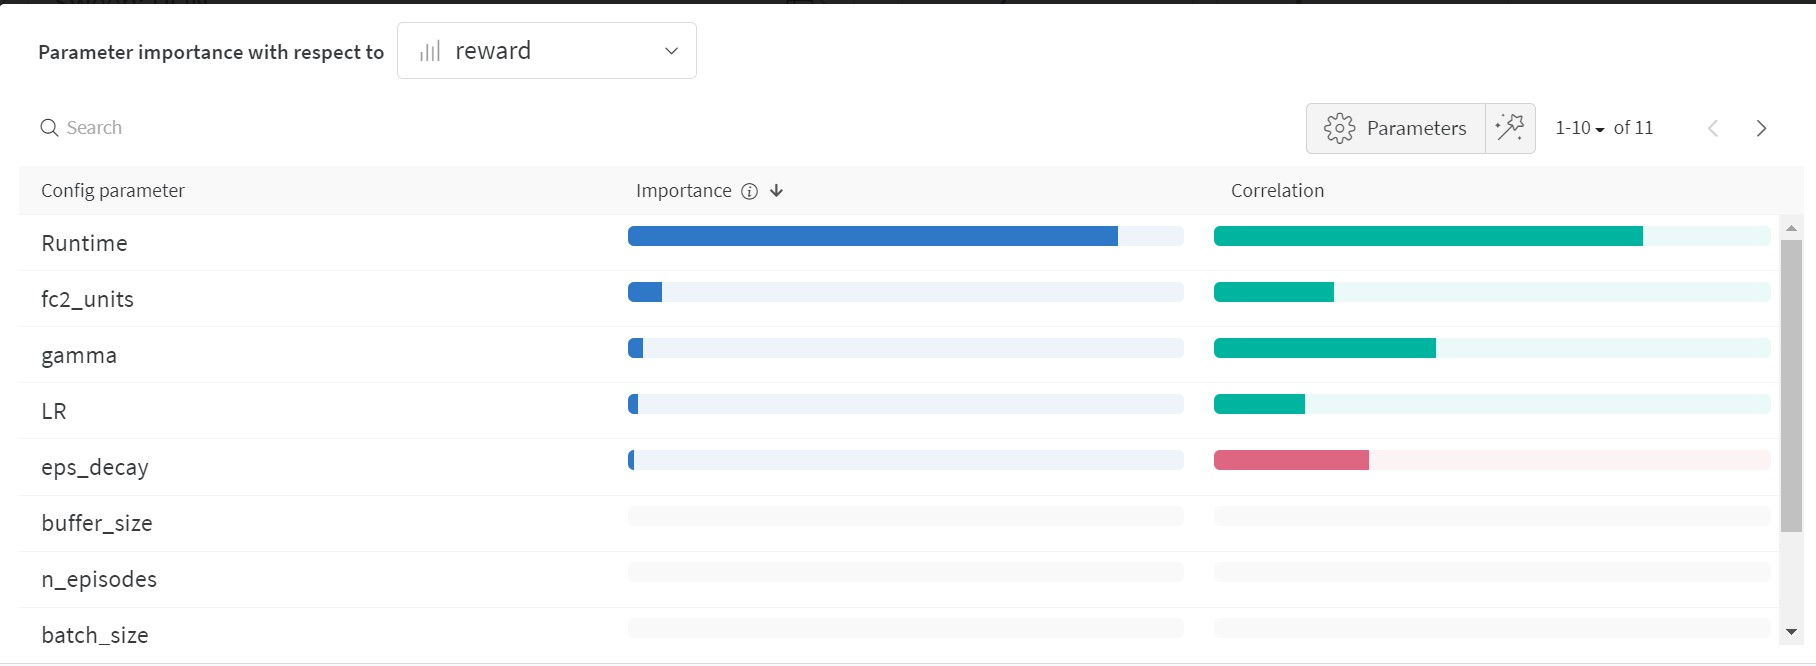

In [9]:


sweep_config = {
  "name": "DQN",
  "method": "bayes",
  "metric": {
      "name": "reward",
      "goal": "maximize",
  },
  "parameters": {
        "buffer_size": {
            "values": [int(1e5)]
        },
        
        "batch_size": {
            "values": [64]
        },
        "n_episodes":{
            "values": [2000]
        },
        "method": {
            "values": ['epsilon']
        },
        "gamma": {
            "values": [0.9,  0.5]
        },
        "LR": {
            "values": [0.01, 0.001,.0001]
        },
         "eps_decay": {
            "values": [0.1, 0.2]
        },
        
        "fc1_units": {
            "values": [64]
        },
        "fc2_units": {
            "values": [64,128]
        },
        
        "optimizer": {
            "values": ['adam']
        },
    }
}





In [10]:
def trainCartPoleEps():
    
    # Initialize a new wandb run
    run = wandb.init()

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Set the run name
    name = str(config["n_episodes"]) + "_"
    name += " batch_size(" + str(config["batch_size"]) + ")_"
    name += "method(" + str(config["method"])+ ")_"
    name += "LR(" + str(config["LR"])+ ")_"
    name += "gamma(" + str(config["gamma"]) + ")_"
    name += "fc1_units(" + str(config["fc1_units"]) + ")_"
    name += "fc2_units(" + str(config["fc2_units"]) + ")_"
    name += "optimizer(" + str(config["optimizer"]) + ")_"
    name += "eps_decay(" + str(config["eps_decay"]) + ")"
    

    wandb.run.name = name[:-1]
    agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
             fc1_units= config["fc1_units"], fc2_units= config["fc2_units"],optimizer= config["optimizer"],momentum_decay=0.99)
    detailsAcrobotSoftmax1=dqn(agent=agent,n_episodes=config["n_episodes"],method='epsilon',\
                    buffer_size = config["buffer_size"] ,eps_decay=config["eps_decay"],\
                    batch_size = config["batch_size"] ,gamma =  config["gamma"],\
                    LR =  config["LR"],update_every = 20,\
                    scoreThreshold=190,wandbLog=True)
    
    rew = np.mean(np.average(detailsAcrobotSoftmax1[0], 0))
    wandb.log({'reward': rew })
    #wandb.log({'Value Function': wandb.plots.HeatMap(list(range(10)), list(range(10)), Q.copy())})

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="kankan-jana", project="RL_Assignment2")
wandb.agent(sweep_id, trainCartPoleEps)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: ae1bfrvt
Sweep URL: https://wandb.ai/kankan-jana/RL_Assignment2/sweeps/ae1bfrvt


wandb: Agent Starting Run: 4h5owicm with config:
wandb: 	LR: 0.001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	eps_decay: 0.2
wandb: 	fc1_units: 64
wandb: 	fc2_units: 64
wandb: 	gamma: 0.9
wandb: 	method: epsilon
wandb: 	n_episodes: 2000
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kankan-jana (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Episode 100	Average Score: 28.79
Episode 109	Average Score: 42.07

### CartPole-v0 : Sweep configuration with Softmax

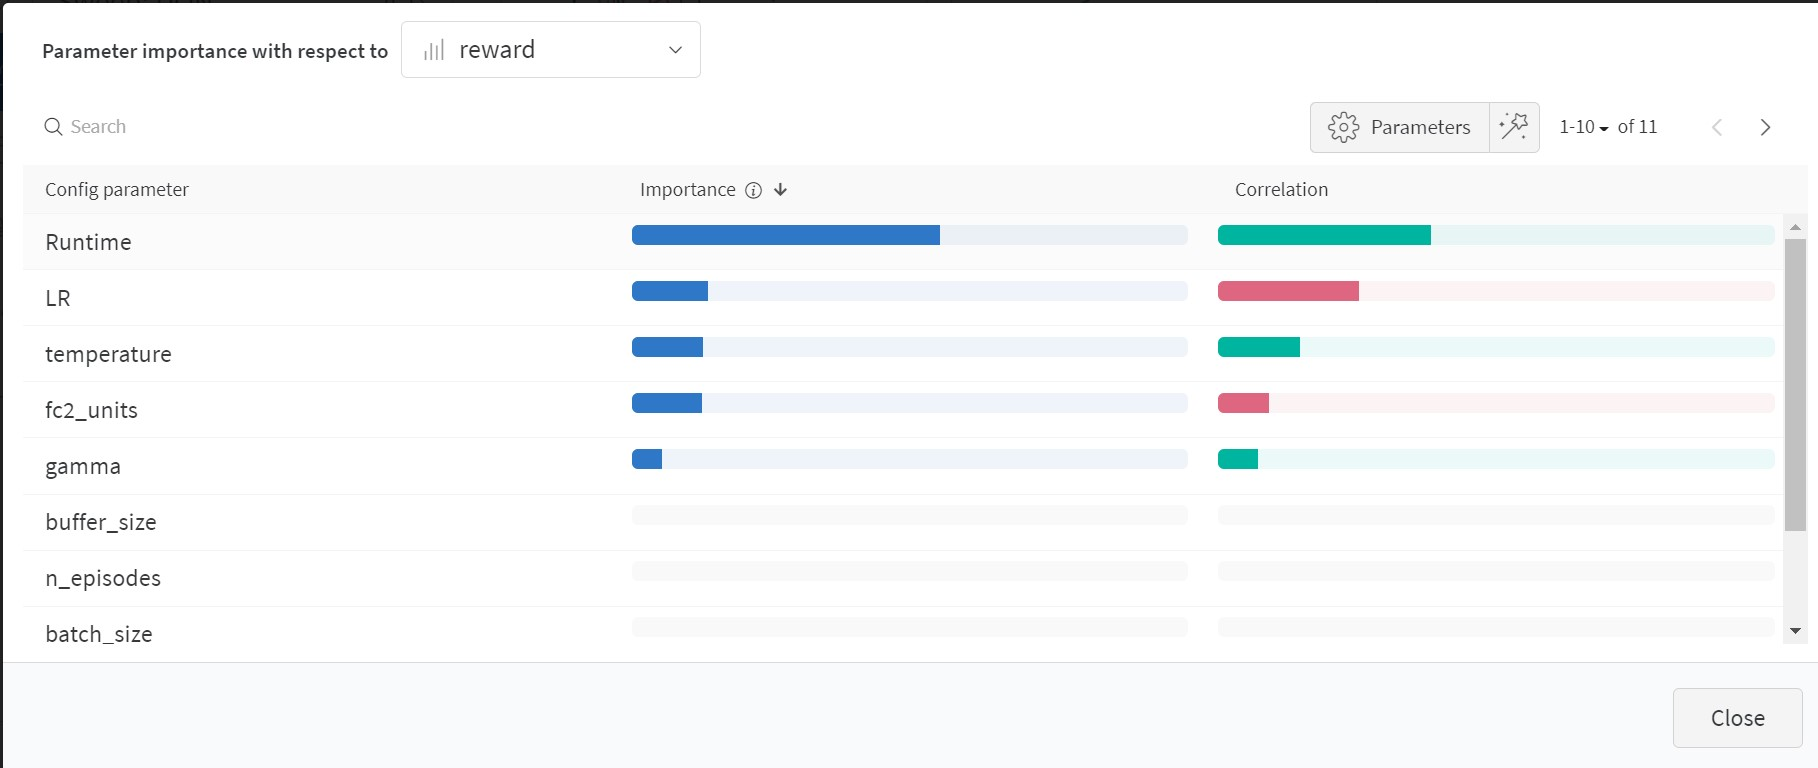

In [25]:


sweep_config = {
  "name": "DQN",
  "method": "bayes",
  "metric": {
      "name": "reward",
      "goal": "maximize",
  },
  "parameters": {
        "buffer_size": {
            "values": [int(1e5)]
        },
        
        "batch_size": {
            "values": [64]
        },
        "n_episodes":{
            "values": [500]
        },
        "method": {
            "values": ['softmax']
        },
        "gamma": {
            "values": [0.99,.5]
        },
        "LR": {
            "values": [.0001]
        },
         "temperature": {
            "values": [0.001, 0.9]
        },
        
        "fc1_units": {
            "values": [64,128]
        },
        "fc2_units": {
            "values": [64,128]
        },
        
        "optimizer": {
            "values": ['adam']
        },
    }
}





In [28]:
def trainCartPoleSoftmax():
    
    # Initialize a new wandb run
    run = wandb.init()

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Set the run name
    name = str(config["n_episodes"]) + "_cartpole_"
    name += " batch_size(" + str(config["batch_size"]) + ")_"
    name += "method(" + str(config["method"])+ ")_"
    name += "LR(" + str(config["LR"])+ ")_"
    name += "gamma(" + str(config["gamma"]) + ")_"
    name += "fc1_units(" + str(config["fc1_units"]) + ")_"
    name += "fc2_units(" + str(config["fc2_units"]) + ")_"
    name += "optimizer(" + str(config["optimizer"]) + ")_"
    name += "temperature(" + str(config["temperature"]) + ")"
    

    wandb.run.name = name[:-1]
    agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
             fc1_units= config["fc1_units"], fc2_units= config["fc2_units"],optimizer= config["optimizer"],momentum_decay=0.99)
    detailsAcrobotSoftmax1=dqn(agent=agent,n_episodes=config["n_episodes"],method='epsilon',\
                    buffer_size = config["buffer_size"] ,temperature=config["temperature"],\
                    batch_size = config["batch_size"] ,gamma =  config["gamma"],\
                    LR =  config["LR"],update_every = 20,\
                    scoreThreshold=env.spec.reward_threshold,wandbLog=True)
    
    rew = np.mean(np.average(detailsAcrobotSoftmax1[0], 0))
    wandb.log({'reward': rew })
    #wandb.log({'Value Function': wandb.plots.HeatMap(list(range(10)), list(range(10)), Q.copy())})

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="kankan-jana", project="RL_Assignment2")
wandb.agent(sweep_id, trainCartPoleSoftmax)

Create sweep with ID: 13vjeuy9
Sweep URL: https://wandb.ai/kankan-jana/RL_Assignment2/sweeps/13vjeuy9


wandb: Agent Starting Run: ux7r970c with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 64
wandb: 	fc2_units: 64
wandb: 	gamma: 0.99
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Episode 100	Average Score: 39.18
Episode 200	Average Score: 114.10
Episode 300	Average Score: 55.543
Episode 400	Average Score: 239.54
Episode 500	Average Score: 16.855


reward,▂▄▂█▁█
step,▁▃▅▆█
reward,246.521
step,500


wandb: Agent Starting Run: drmbotzy with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 128
wandb: 	fc2_units: 64
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 40.79
Episode 200	Average Score: 142.62
Episode 300	Average Score: 85.237
Episode 400	Average Score: 47.82
Episode 500	Average Score: 57.70


reward,▁▅▃▁▂█
step,▁▃▅▆█
reward,237.416
step,500


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hr7tafqc with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 64
wandb: 	fc2_units: 128
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 48.70
Episode 200	Average Score: 124.79
Episode 300	Average Score: 54.229
Episode 400	Average Score: 10.54
Episode 500	Average Score: 78.36


reward,▂▅▂▁▃█
step,▁▃▅▆█
reward,231.661
step,500


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: woyc2x3t with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 64
wandb: 	fc2_units: 128
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 48.69
Episode 200	Average Score: 113.21
Episode 300	Average Score: 39.371
Episode 400	Average Score: 127.95
Episode 500	Average Score: 115.96


reward,▁▄▁▄▄█
step,▁▃▅▆█
reward,244.518
step,500


wandb: Agent Starting Run: 0n329c9q with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 128
wandb: 	fc2_units: 64
wandb: 	gamma: 0.99
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 38.12
Episode 200	Average Score: 135.62
Episode 300	Average Score: 131.56
Episode 400	Average Score: 32.193
Episode 500	Average Score: 16.33


reward,▂▅▅▂▁█
step,▁▃▅▆█
reward,235.382
step,500


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ng2i6w3g with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 128
wandb: 	fc2_units: 64
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 40.22
Episode 200	Average Score: 126.13
Episode 300	Average Score: 101.89
Episode 400	Average Score: 10.638
Episode 500	Average Score: 10.00


reward,▂▅▄▁▁█
step,▁▃▅▆█
reward,228.887
step,500


wandb: Agent Starting Run: w08994m0 with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 128
wandb: 	fc2_units: 64
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 39.50
Episode 200	Average Score: 165.95
Episode 300	Average Score: 102.23
Episode 400	Average Score: 11.302
Episode 500	Average Score: 64.53


reward,▂▆▄▁▃█
step,▁▃▅▆█
reward,238.351
step,500


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p3j8u9ht with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 128
wandb: 	fc2_units: 64
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 40.17
Episode 200	Average Score: 158.16
Episode 300	Average Score: 98.901
Episode 400	Average Score: 10.81
Episode 500	Average Score: 10.10


reward,▂▆▄▁▁█
step,▁▃▅▆█
reward,231.814
step,500


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 821hf1ot with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 128
wandb: 	fc2_units: 128
wandb: 	gamma: 0.99
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 47.26
Episode 200	Average Score: 100.63
Episode 300	Average Score: 117.18
Episode 400	Average Score: 84.414
Episode 500	Average Score: 67.858


reward,▁▃▄▂▂█
step,▁▃▅▆█
reward,241.733
step,500


wandb: Agent Starting Run: zjdvbmzu with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 64
wandb: 	fc2_units: 64
wandb: 	gamma: 0.99
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 39.01
Episode 200	Average Score: 113.06
Episode 300	Average Score: 104.82
Episode 400	Average Score: 20.554
Episode 500	Average Score: 48.97


reward,▂▄▄▁▂█
step,▁▃▅▆█
reward,232.641
step,500


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t9x36gla with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 64
wandb: 	fc2_units: 64
wandb: 	gamma: 0.99
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 36.05
Episode 200	Average Score: 119.42
Episode 300	Average Score: 72.974
Episode 400	Average Score: 32.16
Episode 500	Average Score: 53.68


reward,▁▄▂▁▂█
step,▁▃▅▆█
reward,231.428
step,500


wandb: Agent Starting Run: 8r9uewol with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 128
wandb: 	fc2_units: 128
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 52.84
Episode 200	Average Score: 148.32
Episode 300	Average Score: 99.700
Episode 400	Average Score: 12.42
Episode 500	Average Score: 94.99


reward,▂▅▄▁▄█
step,▁▃▅▆█
reward,240.827
step,500


wandb: Agent Starting Run: ycft5oix with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 128
wandb: 	fc2_units: 128
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 39.45
Episode 200	Average Score: 139.41
Episode 300	Average Score: 236.90
Episode 400	Average Score: 158.40
Episode 500	Average Score: 32.068


reward,▁▄▇▅▁█
step,▁▃▅▆█
reward,260.622
step,500


wandb: Agent Starting Run: bpiaco55 with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 128
wandb: 	fc2_units: 128
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 43.92
Episode 200	Average Score: 110.61
Episode 300	Average Score: 43.881
Episode 392	Average Score: 158.80

wandb: Network error (ConnectionError), entering retry loop.


Episode 400	Average Score: 196.55
Episode 500	Average Score: 332.09


reward,▁▃▁▅█▇
step,▁▃▅▆█
reward,272.705
step,500


wandb: Agent Starting Run: jfwydpu2 with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 64
wandb: 	fc2_units: 64
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 41.25
Episode 200	Average Score: 112.18
Episode 300	Average Score: 36.108
Episode 400	Average Score: 86.39
Episode 500	Average Score: 362.59


reward,▁▃▁▂█▆
step,▁▃▅▆█
reward,263.851
step,500


wandb: Agent Starting Run: 06w2yd4h with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 64
wandb: 	fc2_units: 64
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 39.00
Episode 200	Average Score: 135.94
Episode 300	Average Score: 88.817
Episode 400	Average Score: 12.66
Episode 500	Average Score: 65.62


reward,▂▅▃▁▃█
step,▁▃▅▆█
reward,234.203
step,500


wandb: Agent Starting Run: 0u2yt02d with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 64
wandb: 	fc2_units: 64
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 44.69
Episode 200	Average Score: 118.76
Episode 300	Average Score: 36.736
Episode 400	Average Score: 84.57
Episode 496	Average Score: 212.59

wandb: Network error (ConnectionError), entering retry loop.


Episode 500	Average Score: 232.16


reward,▁▄▁▃▇█
step,▁▃▅▆█
reward,251.691
step,500


wandb: Agent Starting Run: 0mo2s5ry with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 64
wandb: 	fc2_units: 64
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Episode 100	Average Score: 45.90
Episode 200	Average Score: 114.36
Episode 300	Average Score: 49.848
Episode 400	Average Score: 75.45
Episode 500	Average Score: 124.65


reward,▁▃▁▂▄█
step,▁▃▅▆█
reward,241.02
step,500


wandb: Agent Starting Run: bm1p87eh with config:
wandb: 	LR: 0.0001
wandb: 	batch_size: 64
wandb: 	buffer_size: 100000
wandb: 	fc1_units: 128
wandb: 	fc2_units: 128
wandb: 	gamma: 0.5
wandb: 	method: softmax
wandb: 	n_episodes: 500
wandb: 	optimizer: adam
wandb: 	temperature: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 100	Average Score: 47.61
Episode 170	Average Score: 121.14

In [96]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE =128       #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = 5e-4               #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''
fc1_units=64
fc1_units=64
eps_decay=0.9
detailsconfig1avg=[]
detailsconfig1=[]
stepsconfig1=[]
n_episodes=1000

temperature=0.9
method='epsilon'
for i in range(10):
  print('start experiment'+str(i+1))
  env = gym.make('CartPole-v1')
  env.seed(0)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  state = env.reset()   
  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
               fc1_units=fc1_units, fc2_units=fc2_units,optimizer='adam')
  details1avg,details1,steps=dqn(agent=agent,n_episodes=n_episodes,method=method,\
                      buffer_size =BUFFER_SIZE,\
                      batch_size = BATCH_SIZE ,gamma = GAMMA,\
                      LR = LR,update_every = UPDATE_EVERY,\
                      eps_decay=eps_decay,scoreThreshold=env.spec.reward_threshold)#,temperature=0.9)

  time_taken = datetime.datetime.now() - begin_time
  detailsconfig1.append(details1)
  detailsconfig1avg.append(details1avg)
  stepsconfig1.append(steps)

  print(time_taken)
  print('Complete experiment'+str(i+1))

start experiment1
Episode 100	Average Score: 79.91
Episode 200	Average Score: 340.17
Episode 300	Average Score: 287.69
Episode 400	Average Score: 308.19
Episode 500	Average Score: 24.520
Episode 600	Average Score: 26.13
Episode 700	Average Score: 16.08
Episode 800	Average Score: 47.23
Episode 900	Average Score: 28.75
Episode 1000	Average Score: 9.72
0:13:58.879226
Complete experiment1
start experiment2
Episode 100	Average Score: 79.91
Episode 200	Average Score: 340.17
Episode 300	Average Score: 287.69
Episode 400	Average Score: 308.19
Episode 500	Average Score: 24.520
Episode 600	Average Score: 26.13
Episode 700	Average Score: 16.08
Episode 800	Average Score: 47.23
Episode 900	Average Score: 28.75
Episode 1000	Average Score: 9.72
0:11:49.166121
Complete experiment2
start experiment3
Episode 100	Average Score: 79.91
Episode 200	Average Score: 340.17
Episode 300	Average Score: 287.69
Episode 400	Average Score: 308.19
Episode 500	Average Score: 24.520
Episode 600	Average Score: 26.13
Epis

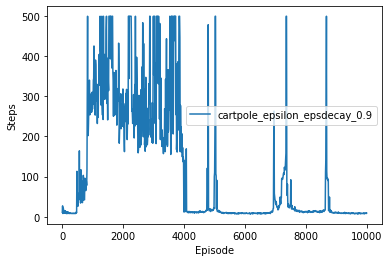

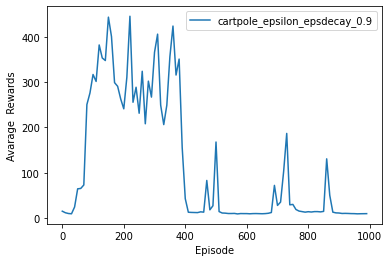

In [97]:

detailsAfig1__ = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig1)]
stepsconfig1__=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig1)]
detailsconfig1avg__ =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig1avg)]


plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig1__))*10,stepsconfig1__,LABEL='cartpole_epsilon_epsdecay_0.9')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig1avg__[0]))*10,detailsconfig1avg__[0],LABEL='cartpole_epsilon_epsdecay_0.9')

plt.legend()
plt.show()



In [89]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE =128         #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = 5e-4               #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''
fc1_units=64
fc1_units=64
eps_decay=0.1
detailsconfig1avg=[]
detailsconfig1=[]
stepsconfig1=[]
n_episodes=1000

temperature=0.9
method='epsilon'
for i in range(10):
  print('start experiment'+str(i+1))
  env = gym.make('CartPole-v1')
  env.seed(0)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  state = env.reset()   
  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
               fc1_units=fc1_units, fc2_units=fc2_units,optimizer='adam')
  details1avg,details1,steps=dqn(agent=agent,n_episodes=n_episodes,method=method,\
                      buffer_size =BUFFER_SIZE,\
                      batch_size = BATCH_SIZE ,gamma = GAMMA,\
                      LR = LR,update_every = UPDATE_EVERY,\
                      eps_decay=eps_decay,scoreThreshold=env.spec.reward_threshold)#,temperature=0.9)

  time_taken = datetime.datetime.now() - begin_time
  detailsconfig1.append(details1)
  detailsconfig1avg.append(details1avg)
  stepsconfig1.append(steps)

  print(time_taken)
  print('Complete experiment'+str(i+1))

start experiment1
Episode 100	Average Score: 28.79
Episode 200	Average Score: 443.75
Episode 211	Average Score: 477.30
Environment solved in 111 episodes!	Average Score: 477.30
0:07:07.431233
Complete experiment1
start experiment2
Episode 100	Average Score: 28.79
Episode 200	Average Score: 443.75
Episode 211	Average Score: 477.30
Environment solved in 111 episodes!	Average Score: 477.30
0:08:15.766937
Complete experiment2
start experiment3
Episode 100	Average Score: 28.79
Episode 200	Average Score: 443.75
Episode 211	Average Score: 477.30
Environment solved in 111 episodes!	Average Score: 477.30
0:08:25.052415
Complete experiment3
start experiment4
Episode 100	Average Score: 28.79
Episode 200	Average Score: 443.75
Episode 211	Average Score: 477.30
Environment solved in 111 episodes!	Average Score: 477.30
0:06:50.665469
Complete experiment4
start experiment5
Episode 100	Average Score: 28.79
Episode 200	Average Score: 443.75
Episode 211	Average Score: 477.30
Environment solved in 111 epi

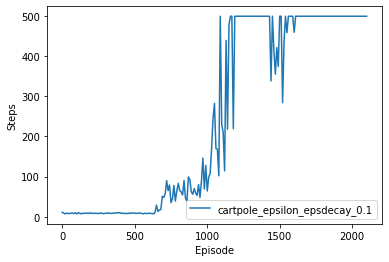

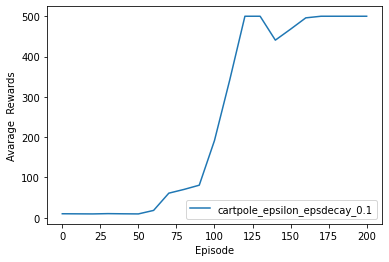

In [92]:

detailsAfig1_ = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig1)]
stepsconfig1_=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig1)]
detailsconfig1avg_ =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig1avg)]


plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig1_))*10,stepsconfig1_,LABEL='cartpole_epsilon_epsdecay_0.1')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig1avg_[0]))*10,detailsconfig1avg_[0],LABEL='cartpole_epsilon_epsdecay_0.1')

plt.legend()
plt.show()



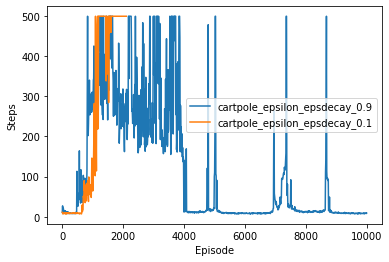

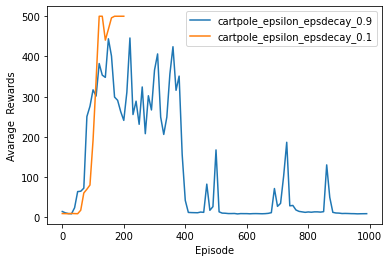

In [98]:



plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig1__))*10,stepsconfig1__,LABEL='cartpole_epsilon_epsdecay_0.9')
plt.plot(np.arange(len(stepsconfig1_))*10,stepsconfig1_,LABEL='cartpole_epsilon_epsdecay_0.1')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig1avg__[0]))*10,detailsconfig1avg__[0],LABEL='cartpole_epsilon_epsdecay_0.9')
plt.plot(np.arange(len(detailsconfig1avg_[0]))*10,detailsconfig1avg_[0],LABEL='cartpole_epsilon_epsdecay_0.1')

plt.legend()
plt.show()



In [106]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE =64         #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = 1e-4               #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''
fc1_units=64
fc1_units=64
eps_decay=0.5
detailsconfig1avg=[]
detailsconfig1=[]
stepsconfig1=[]
n_episodes=1000


method='epsilon'
for i in range(10):
  print('start experiment'+str(i+1))
  env = gym.make('CartPole-v1')
  env.seed(0)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  state = env.reset()   
  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
               fc1_units=fc1_units, fc2_units=fc2_units,optimizer='adam')
  details1avg,details1,steps=dqn(agent=agent,n_episodes=n_episodes,method=method,\
                      buffer_size =BUFFER_SIZE,\
                      batch_size = BATCH_SIZE ,gamma = GAMMA,\
                      LR = LR,update_every = UPDATE_EVERY,\
                      eps_decay=eps_decay,scoreThreshold=env.spec.reward_threshold)#,temperature=0.9)

  time_taken = datetime.datetime.now() - begin_time
  detailsconfig1.append(details1)
  detailsconfig1avg.append(details1avg)
  stepsconfig1.append(steps)

  print(time_taken)
  print('Complete experiment'+str(i+1))

start experiment1
Episode 100	Average Score: 43.67
Episode 200	Average Score: 166.76
Episode 300	Average Score: 42.765
Episode 400	Average Score: 80.69
Episode 500	Average Score: 76.862
Episode 600	Average Score: 75.55
Episode 700	Average Score: 81.919
Episode 800	Average Score: 159.86
Episode 900	Average Score: 80.123
Episode 1000	Average Score: 125.08
0:11:13.056198
Complete experiment1
start experiment2
Episode 100	Average Score: 43.67
Episode 200	Average Score: 166.76
Episode 300	Average Score: 42.765
Episode 400	Average Score: 80.69
Episode 500	Average Score: 76.862
Episode 600	Average Score: 75.55
Episode 700	Average Score: 81.919
Episode 800	Average Score: 159.86
Episode 900	Average Score: 80.123
Episode 1000	Average Score: 125.08
0:11:21.179393
Complete experiment2
start experiment3
Episode 100	Average Score: 43.67
Episode 200	Average Score: 166.76
Episode 300	Average Score: 42.765
Episode 400	Average Score: 80.69
Episode 500	Average Score: 76.862
Episode 600	Average Score: 75.

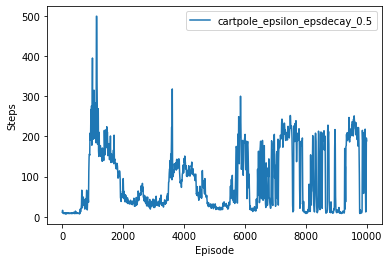

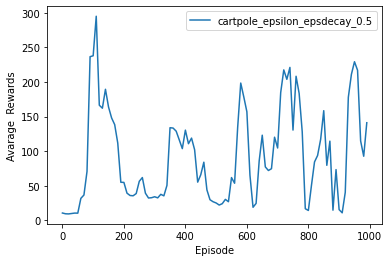

In [109]:

detailsAfig1_1 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig1)]
stepsconfig1_1=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig1)]
detailsconfig1avg_1 =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig1avg)]


plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig1_1))*10,stepsconfig1_1,LABEL='cartpole_epsilon_epsdecay_0.5')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig1avg_1[0]))*10,detailsconfig1avg_1[0],LABEL='cartpole_epsilon_epsdecay_0.5')

plt.legend()
plt.show()



In [113]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE =128         #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = 5e-4               #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''
fc1_units=64
fc1_units=64
eps_decay=0.1
detailsconfig1avg=[]
detailsconfig1=[]
stepsconfig1=[]
n_episodes=1000

temperature=0.9
method='softmax'
for i in range(10):
  print('start experiment'+str(i+1))
  env = gym.make('CartPole-v1')
  env.seed(0)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  state = env.reset()   
  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
               fc1_units=fc1_units, fc2_units=fc2_units,optimizer='adam')
  details1avg,details1,steps=dqn(agent=agent,n_episodes=n_episodes,method=method,temperature=0.9,\
                      buffer_size =BUFFER_SIZE,\
                      batch_size = BATCH_SIZE ,gamma = GAMMA,\
                      LR = LR,update_every = UPDATE_EVERY,\
                      eps_decay=eps_decay,scoreThreshold=env.spec.reward_threshold)#,temperature=0.9)

  time_taken = datetime.datetime.now() - begin_time
  detailsconfig1.append(details1)
  detailsconfig1avg.append(details1avg)
  stepsconfig1.append(steps)

  print(time_taken)
  print('Complete experiment'+str(i+1))

start experiment1
Episode 100	Average Score: 84.33
Episode 200	Average Score: 83.354
Episode 300	Average Score: 29.56
Episode 400	Average Score: 15.57
Episode 500	Average Score: 18.90
Episode 600	Average Score: 16.17
Episode 700	Average Score: 21.40
Episode 800	Average Score: 24.31
Episode 900	Average Score: 157.10
Episode 1000	Average Score: 57.95
0:13:51.845069
Complete experiment1
start experiment2
Episode 100	Average Score: 136.31
Episode 200	Average Score: 93.938
Episode 300	Average Score: 9.902
Episode 400	Average Score: 9.45
Episode 500	Average Score: 10.54
Episode 600	Average Score: 9.398
Episode 700	Average Score: 9.37
Episode 800	Average Score: 16.84
Episode 900	Average Score: 154.22
Episode 988	Average Score: 477.52
Environment solved in 888 episodes!	Average Score: 477.52
0:16:30.749139
Complete experiment2
start experiment3
Episode 100	Average Score: 70.57
Episode 200	Average Score: 81.950
Episode 300	Average Score: 74.09
Episode 400	Average Score: 81.806
Episode 500	Avera

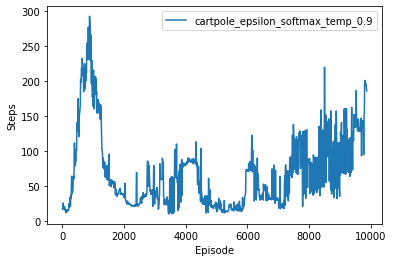

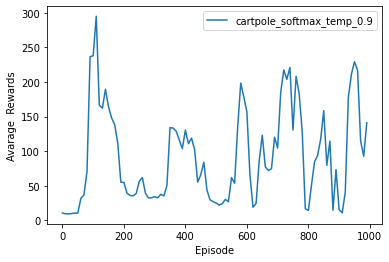

In [115]:

detailsAfig1_1 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig1)]
stepsconfig1_1=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig1)]
detailsconfig1avg_1 =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig1avg)]


plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig1_1))*10,stepsconfig1_1,LABEL='cartpole_epsilon_softmax_temp_0.9')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig1avg_1[0]))*10,detailsconfig1avg_1[0],LABEL='cartpole_softmax_temp_0.9')

plt.legend()
plt.show()



In [ ]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE =128         #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = 5e-4               #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''
fc1_units=64
fc1_units=128
eps_decay=0.2
detailsconfig1avg=[]
detailsconfig1=[]
stepsconfig1=[]
n_episodes=1000

temperature=0.9
method='epsilon'
for i in range(10):
  print('start experiment'+str(i+1))
  env = gym.make('CartPole-v1')
  env.seed(0)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  state = env.reset()   
  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
               fc1_units=fc1_units, fc2_units=fc2_units,optimizer='adam')
  details1avg,details1,steps=dqn(agent=agent,n_episodes=n_episodes,method=method,\
                      buffer_size =BUFFER_SIZE,\
                      batch_size = BATCH_SIZE ,gamma = GAMMA,\
                      LR = LR,update_every = UPDATE_EVERY,\
                      eps_decay=eps_decay,scoreThreshold=env.spec.reward_threshold)#,temperature=0.9)

  time_taken = datetime.datetime.now() - begin_time
  detailsconfig1.append(details1)
  detailsconfig1avg.append(details1avg)
  stepsconfig1.append(steps)

  print(time_taken)
  print('Complete experiment'+str(i+1))

In [ ]:

detailsAfig1_ = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig1)]
stepsconfig1_=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig1)]
detailsconfig1avg_ =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig1avg)]


plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig1_))*10,stepsconfig1_,LABEL='cartpole_epsilon_epsdecay_0.1')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig1avg_[0]))*10,detailsconfig1avg_[0],LABEL='cartpole_epsilon_epsdecay_0.1')

plt.legend()
plt.show()

